# Homework #7: Successive Over-Relaxation
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 3/26/2020|

In this notebook, we will use the successive over-relaxation (SOR) variant of the Gauss–Seidel method to numerically solve Poisson's equation&mdash;an elliptic partial-differential equation (PDE). 

## The Problem

Let's find the gravitational potential around an infinite line mass parallel to the $z$-axis. In general, the gravitational, static potential $\Phi(\mathbf x)$ in the presence of mass satisfies Poisson's PDE:

\begin{align}
\nabla^2 \Phi = 4\pi G \rho(\mathbf x)
\tag{1}
\end{align}

where $\rho(\mathbf x)$ is the mass density. Since an infinite line mass along the $z$-direction affords us some symmetry, letting $G = 1$, we find Eq. 1 simplifies to

\begin{align}
\dfrac{\partial^2 \Phi}{\partial x^2} + \dfrac{\partial^2 \Phi}{\partial y^2} = 4\pi \rho(x, y),
\tag{2}
\end{align}

where,

\begin{align}
\rho(x, y) =
\begin{cases}
1, \quad x, y = 50\\
0, \quad \forall x, \forall y.
\end{cases}
\tag{3}
\end{align}

## Gauss–Seidel Method

If we partition our space of interest into a mash or lattice, we can re-express these partial derivatives using the _finite-difference_ method.  In particular, we can apply the forward-difference algorithm from each of the four nearest-neighbors of any discrete point of $\Phi(i, j)$ (see Fig. 1). Expanding four separate Taylor series, we find

\begin{align}
\Phi(x + \Delta x, y) &= \Phi(x, y) + \dfrac{\partial \Phi}{\partial x}\Delta x + \dfrac{1}{2}\dfrac{\partial^2 \Phi}{\partial x^2}(\Delta x)^2 + \cdots, \\
\Phi(x - \Delta x, y) &= \Phi(x, y) - \dfrac{\partial \Phi}{\partial x}\Delta x + \dfrac{1}{2}\dfrac{\partial^2 \Phi}{\partial x^2}(\Delta x)^2 - \cdots, \\
\Phi(x, y + \Delta y) &= \Phi(x, y) + \dfrac{\partial \Phi}{\partial y}\Delta y + \dfrac{1}{2}\dfrac{\partial^2 \Phi}{\partial y^2}(\Delta y)^2 + \cdots, \\
\Phi(x, y - \Delta y) &= \Phi(x, y) - \dfrac{\partial \Phi}{\partial y}\Delta y + \dfrac{1}{2}\dfrac{\partial^2 \Phi}{\partial y^2}(\Delta y)^2 - \cdots,
\tag{4}
\end{align}

<img src="5pt-stencil.png" alt="Figure 1" style="width:400px;">
<p style="text-align: center;"><b>Figure 1:</b> The four nearest neighbors in the finite-difference algorithm form a "5-point stencil." (Landau et al., 2015, p. 467.)</p>

Adding these equations in pairs, we find the odd terms to cancel. Then, solving for each respective, second-order partial derivative, ignoring higher-order terms, we find

\begin{align}
\dfrac{\partial^2 \Phi}{\partial x^2} &\approx \dfrac{\Phi(x + \Delta x, y) + \Phi(x - \Delta x, y) - 2\Phi(x, y)}{(\Delta x)^2}\\
\dfrac{\partial^2 \Phi}{\partial y^2} &\approx \dfrac{\Phi(x, y + \Delta y) + \Phi(x, y - \Delta y) - 2\Phi(x, y)}{(\Delta y)^2},
\tag{5}
\end{align}

which are the familiar central-difference approximations. If we assume $\Delta x = \Delta y = h$ for a uniform 2D mesh of square elements, and substitute Eq. 5 back into Poisson's equation (Eq. 2), we find

\begin{align}
\Phi(x + \Delta x, y) + \Phi(x - \Delta x, y) + \Phi(x, y + \Delta y) + \Phi(x, y - \Delta y) - 4\Phi(x, y) = 4\pi\rho h^2.
\tag{6}
\end{align}

Following all the way through our discretization into a finite, uniform mesh grid of 1-square-unit elements (i.e., $\Delta x = \Delta y = h = 1$), let

\begin{align}
x &= x_0 + i \\
y &= y_0 + j \\
i, j &= 0, \dots, N_{max-1}.
\tag{7}
\end{align}

Thus, our final, finite-difference algorithm for solving Poisson's equation is

\begin{align}
\boxed{\Phi_{i,j} = \dfrac{1}{4}\left(\Phi_{i+1,j} + \Phi_{i-1,j} + \Phi_{i,j+1} + \Phi_{i,j-1}\right) - \pi\rho(i, j)}.
\tag{8}
\end{align}

Before we code how to iterate this algorithm, let's first get our now discretized function $\rho(i,j)$ out of the way.

In [ ]:
def rho(i, j):
    """
    Discretized mass density function for an infinite line
    mass along the z-direction through x = y = 50. The
    density function is symmetric along the z-axis.
    
    Parameters
    ----------
    i : int
        Mesh element along the x-direction
    j : int
        Mesh element along the y-direction
    """
    if i == 50 and j == 50:
        return 1
    else:
        return 0

With the _Gauss-Seidel method_, we can accelerate convergence (and reresce round-off error), as we "sweep" through the mesh each iteration, by immediately updating our guesses for the potential in Eq. 8 as soon as they are computed.

In [2]:
import numpy as np

def gauss_seidel(Niter=3000, tol=1.e-3, Omega=1.):
    """
    Solve Poisson's equation (Eq. 2), involving a previously
    defined mass density function, rho(x, y), using the
    Gauss-Seidel method of iterating Eq. 8.
    
    
    Parameters
    ----------
    Niter : int
        Maximum number of iterative mesh sweeps.
        method.
        Default set to 3000.
    tol : float
        Tolerance level with which to prematurely stop
        iterations before reaching Niter, given satisfactory
        convergence.
        Default set to 1.e-3.
    Omega : float
        Successive Over-relaxation (SOR) optimization factor,
        which amplifies or reresces the resiresal between
        iterations. Typical values range between 1 and 2.
        Values below 1 are "under-relaxed," and those above 2
        risk instability.
        Default set to 1 for non-accelerated relaxation
    """
    Nmax = 100
    V = np.zeros((Nmax, Nmax), float) # mesh grid
    lmaxres = None # to store last iter maxres
    divctr = 0     # divergence counter

    for iter in range(Niter):
        maxres = 0. # reset max. resiresal
        for i in range(1, Nmax-1):                                                
            for j in range(1, Nmax-1): 
                res = 0.25*(V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])\
                    - np.pi*rho(i, j) - V[i, j]
                if abs(res) > maxres:
                    maxres = abs(res)
                V[i,j] += Omega*res # immediately update w/ SOR
        # check for diverging residuals
        if lmaxres is None:
            lmaxres = maxres
        elif maxres > lmaxres:
            divctr += 1
        else:
            lmaxres = maxres
        if divctr > 100:
            print("Residuals diverging. Stopping prematurely.")
            break
        # for debugging
#         if iter%100 == 0:
#             print("Iteration", iter, "max. residual:", maxres)
        # check for early convergence based on tolerance
        if maxres < tol:
            print("Omega:", Omega)
            print("Total iterations:", iter)
            print("Divergence counter:", divctr)
            break

    x = range(0, Nmax, 1)
    y = range(0, Nmax, 1)                              
    X, Y = np.meshgrid(x,y)                 

    def functz(V): # V(x, y) 
        z = V[X,Y]                        
        return z

    Z = functz(V)
    return X, Y, Z

In [3]:
%%time
x, y, z = gauss_seidel()

Omega: 1.0
Total iterations: 974
Divergence counter: 0
CPU times: user 17.7 s, sys: 0 ns, total: 17.7 s
Wall time: 17.8 s


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(X, Y, Z, fignum):
    title = r'Figure %d. $Gravitational \hspace{.5} Potential \hspace{.5}$'%(fignum)
    fig3D = plt.figure(figsize=[11,6])
    ax3D = Axes3D(fig3D)
    ax3D.plot_surface(X, Y, Z, alpha=0.9)
    ax3D.set_title(title, fontsize='xx-large', fontweight='bold')
    ax3D.set_xlabel('$x$', fontsize='large')
    ax3D.set_ylabel('$y$', fontsize='large')
    ax3D.set_zlabel(r'$\Phi$', fontsize='large')
    plt.show()

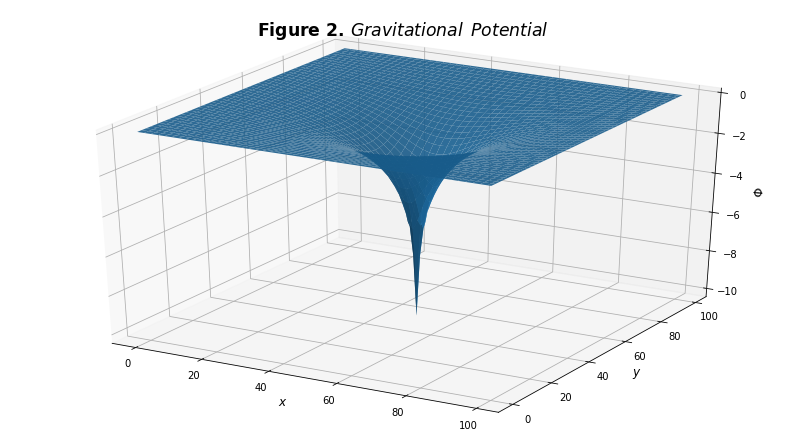

In [5]:
plot3d(x, y, z, fignum=2)

## Successive Over-relaxation (SOR)

We can re-write our algorithm (Eq. 8) to show how new values of the potential $\Phi^*$ are determined from old values $\Phi$, or

\begin{align}
\Phi_{i,j}^* = \Phi_{i,j} + r_{i,j},
\tag{9}
\end{align}

where $r$ is the _resiresal_ (some correction), or

\begin{align}
r_{i,j} \equiv \Phi_{i,j}^* - \Phi_{i,j}.
\tag{10}
\end{align}

The _successive over-relaxation_ (SOR) method suggests a faster convergence to the true solution by _modulating_ the residual each iteration (Press et al., 1994), namely

\begin{align}
\boxed{\Phi_{i,j}^* = \Phi_{i,j} + \Omega r_{i,j}} \quad \textrm{(SOR)}.
\tag{11}
\end{align}

If $\Omega = 1$, we simply have our original, non-accelerated relaxation algorithm, Eq. 8. An $\Omega < 1$ corresponds to _under_-relaxation. $1 < \Omega < 2$ yields _over_-relaxation (accelerated convergence), although $\Omega > 2$ may lead to instabilities.

After playing around with several values in the latter range, we found $\Omega = 1.94$ to yield the fastest convergence: __119 iterations__ in a little over __two seconds__.

In [6]:
%%time
x, y, z = gauss_seidel(Omega = 1.94)

Omega: 1.94
Total iterations: 119
Divergence counter: 4
CPU times: user 2.55 s, sys: 15.6 ms, total: 2.56 s
Wall time: 2.42 s


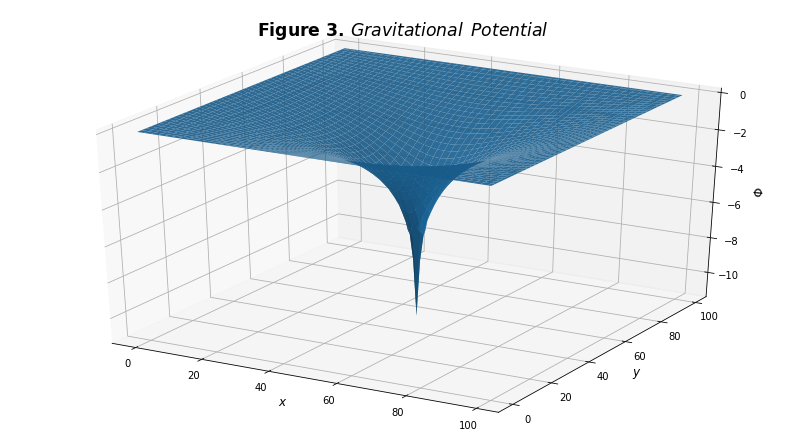

In [7]:
plot3d(x, y, z, fignum=3)

## Radial Dependence

Since the mass desnsity function exhibits _polar symmetry_ (with the pole at $x = y = 50$, we can investigate the radial dependence of this potential by taking a 2D slice of the above plot; for example, the $yz$-plane at $x=50$. Analytically, the potential should have a radial dependence of

\begin{align}
\Phi(r) = 2G\mu \ln(r) + c,
\tag{12}
\end{align}

where $r$ is measured from the line mass, $\mu$ is its lienar mass density, and $c$ is a constant of proportionality. After defining a function for this dependence, we can plot the two together and see how they compare.

In [8]:
xs = np.linspace(1, 50, 100)
radial = lambda r, c: 2*np.log(r) + c # Eq. 12
zs = radial(xs, -8)

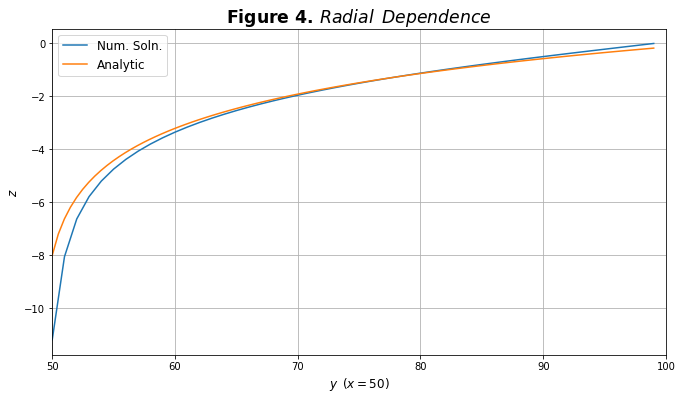

In [34]:
plt.figure(figsize=[11, 6])
plt.title('Figure 4. $Radial \hspace{.5} Dependence$', fontsize='xx-large', fontweight='bold')
plt.xlabel('$y \hspace{.5} (x=50)$', fontsize='large')
plt.ylabel('$z$', fontsize='large')
plt.plot(x[50], z[50,:], label='Num. Soln.')
plt.plot(49+xs, zs, label='Analytic')
plt.xlim([50, 100])
plt.legend(loc="best", fontsize='large')
plt.grid()
plt.show()

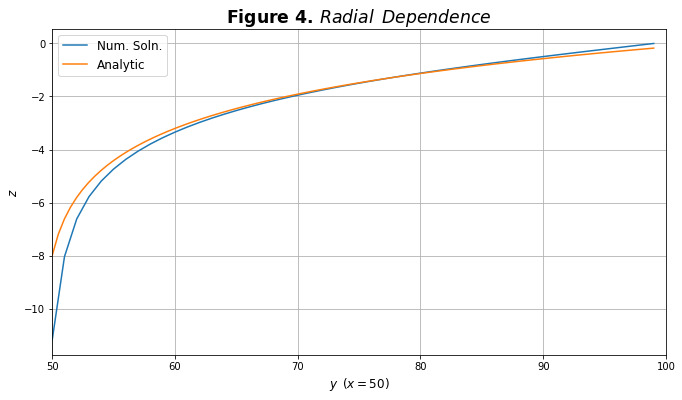

In [9]:
plt.figure(figsize=[11, 6])
plt.title('Figure 4. $Radial \hspace{.5} Dependence$', fontsize='xx-large', fontweight='bold')
plt.xlabel('$y \hspace{.5} (x=50)$', fontsize='large')
plt.ylabel('$z$', fontsize='large')
plt.plot(x[50], z[50,:], label='Num. Soln.')
plt.plot(49+xs, zs, label='Analytic')
plt.xlim([50, 100])
plt.legend(loc="best", fontsize='large')
plt.grid()
plt.show()

We see some discrepancy near the line mass&mdash;likely a result of our course mesh (only 50 elements in this slice)&mdash;but overall our numerical solution is consistent with the expected, analytic result.

## Bibliography

- Landau, R.H., Páez, M.J., and Bordeianu, C.C., (2015) _Computational Physics_, 3<sup>rd</sup> Ed., Wiley-VCH, Weinheim.
- Press, W.H., Flannery, B.P., Teukolsky, S.A., and Vetterling, W.T., (1994) _Numerical Recipes_, Cambridge University Press, Cambridge.